# Setting up

Run the following commands to setup your virtual environment and install the dependencies. </br>
``python -m venv .venv`` </br>
```pip install -r requirements.txt```

# Imports

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, BackendSampler
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import VQD, VQE, SamplingVQE, NumPyEigensolver
from qiskit_algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit_algorithms.gradients import DerivativeType, LinCombQGT, LinCombEstimatorGradient
from qiskit_algorithms.state_fidelities import BaseStateFidelity, ComputeUncompute

from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition
from qiskit_nature.second_q.hamiltonians.ising_model import IsingModel
from qiskit.quantum_info import Operator
# from qiskit.quantum_info.operators.base_operator import BaseOperator

import matplotlib.pyplot as plt

from qiskit import Aer
import numpy as np

We are first going to use Aer to test our code and once we have it working we can increase the number of qubits and submit a job to the Quantinuum emulator

In [2]:
simulator = Aer.get_backend('aer_simulator')

In [3]:
class Params:
    def __init__(self, num_qubits: int, no_of_states_to_compute: int, use_quant, 
                 uniform_interaction, uniform_onsite_potential):
        self.num_qubits = num_qubits
        self.no_of_states_to_compute = no_of_states_to_compute
        self.hamiltonian_op = self.__get_hamiltonian__(uniform_interaction, uniform_onsite_potential)
        self.use_quant = use_quant
    
            
    
    def __get_hamiltonian__(self, uniform_interaction, uniform_onsite_potential):
        line_lattice = LineLattice(num_nodes=self.num_qubits, boundary_condition=BoundaryCondition.OPEN)

        ising_model = IsingModel(
            line_lattice.uniform_parameters(
                uniform_interaction,
                uniform_onsite_potential
            ),
        )
        ham = ising_model.second_q_op()
        ham_operator = Operator(ham.to_matrix())
        eivs = list(np.linalg.eigvals(ham_operator))
        eivs.sort()
        # print('numpy soln', eivs)
        return SparsePauliOp.from_operator(ham_operator)

In [4]:
counts = []
values = []
steps = []

def reset_counts_values_steps():
    global counts
    global values
    global steps
    counts = []
    values = []
    steps = []
    
def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [5]:
def aer_sim():
    # set parameters
    optimizer_cobyla = COBYLA(maxiter=500)
    params = Params(num_qubits = 3, no_of_states_to_compute = 6, use_quant = False, 
                    uniform_interaction=-1.0, uniform_onsite_potential=-0.4)
    betas = [1]*params.no_of_states_to_compute
    ansatz = EfficientSU2(params.num_qubits, entanglement="linear")

    estimator = Estimator()
    sampler = BackendSampler(simulator)
    fidelity = ComputeUncompute(sampler)

    vqd = VQD(estimator, fidelity, ansatz, optimizer_cobyla, k=params.no_of_states_to_compute, betas=betas, callback=callback)
    result = vqd.compute_eigenvalues(params.hamiltonian_op)
    print('VQD res: ', result.eigenvalues.real)

    exact_solver = NumPyEigensolver(k=params.no_of_states_to_compute)
    exact_result = exact_solver.compute_eigenvalues(params.hamiltonian_op)
    ref_values = exact_result.eigenvalues
    print('Sim res: ', ref_values)

    steps_np = np.asarray(steps)
    counts_np = np.asarray(counts)
    values_np = np.asarray(values)
    reset_counts_values_steps()

    for i in range(1, params.no_of_states_to_compute+1):
        _counts = counts_np[np.where(steps_np == i)]
        _values = values_np[np.where(steps_np == i)]
        plt.plot(_counts, _values, label=f"State {i-1}")

    plt.xlabel("Eval count")
    plt.ylabel("Energy")
    plt.title("Energy convergence for each computed state")
    plt.legend(loc="upper right")
    plt.show()


VQD res:  [-0.75169993 -0.58205546 -0.1946887   0.1285118   0.09003485  0.11352747]
Sim res:  [-0.75225553 -0.60900802 -0.2        -0.05675249  0.05675249  0.2       ]


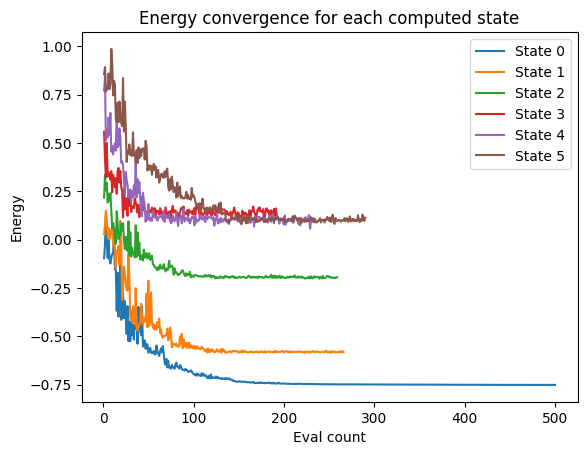

In [6]:
aer_sim()

# Transition Probability